In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [34]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


In [35]:
airbnb_df = pd.read_csv('Airbnb Austin Project/airbnb_cleaned_2.csv')
airbnb_df.head()

,Unnamed: 0,host_since,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,property_type,room_type,accommodates,...,extra_people,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,cancellation_policy
0,0,2011.0,0,1.0,1,0,Circle C,House,Private room,6,...,0.0,2,1,0,0,0,240,1,0,moderate
1,1,2015.0,0,1.0,1,1,Circle C,Camper/RV,Private room,2,...,0.0,3,1,29,59,89,364,0,0,moderate
2,5,2015.0,0,1.0,1,0,Circle C,House,Private room,2,...,0.0,1,1,30,60,90,365,0,0,flexible
3,7,2014.0,0,1.0,1,1,Circle C,House,Private room,2,...,10.0,1,1,16,16,37,312,2,1,moderate
4,10,2015.0,0,1.0,1,0,Circle C,House,Private room,2,...,0.0,2,1,29,59,89,364,0,0,strict


In [36]:
airbnb_df.dtypes

Unnamed: 0                  int64
host_since                float64
host_is_superhost           int64
host_listings_count       float64
host_has_profile_pic        int64
host_identity_verified      int64
neighbourhood              object
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
bed_type                   object
amenities                   int64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
has_availability            int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
instant_bookable            int64
cancellation_policy        object
dtype: object

In [37]:
airbnb_numerical = airbnb_df.drop(columns=['neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy'])
airbnb_numerical.dtypes

Unnamed: 0                  int64
host_since                float64
host_is_superhost           int64
host_listings_count       float64
host_has_profile_pic        int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
amenities                   int64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
has_availability            int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
instant_bookable            int64
dtype: object

In [38]:
X = airbnb_numerical.drop(columns=['price'])
y = airbnb_numerical['price']

stepwise_variables = stepwise_selection(X, y)

Add  bathrooms with p-value 0.0000
Add  has_availability with p-value 0.0000
Add  bedrooms with p-value 0.0000
Add  host_identity_verified with p-value 0.0000
Add  guests_included with p-value 0.0000
Add  host_is_superhost with p-value 0.0000
Add  accommodates with p-value 0.0000
Add  extra_people with p-value 0.0000
Add  number_of_reviews with p-value 0.0004


In [39]:
#Stepwise Logistic Regression with Numerical variables
X = airbnb_numerical[stepwise_variables]
y = airbnb_numerical['price']
X = sm.add_constant(X)

numerical_logreg = sm.OLS(y, X).fit()

print(numerical_logreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     361.5
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:00:34   Log-Likelihood:                -34103.
No. Observations:                4751   AIC:                         6.822e+04
Df Residuals:                    4742   BIC:                         6.828e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
bathrooms                210

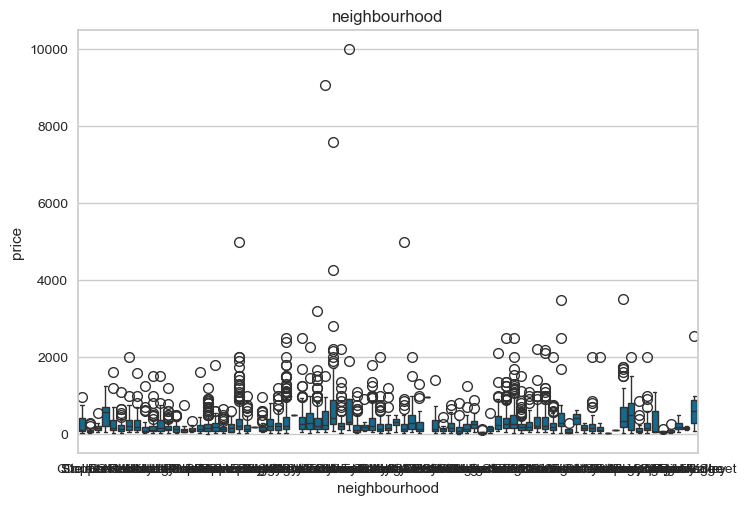

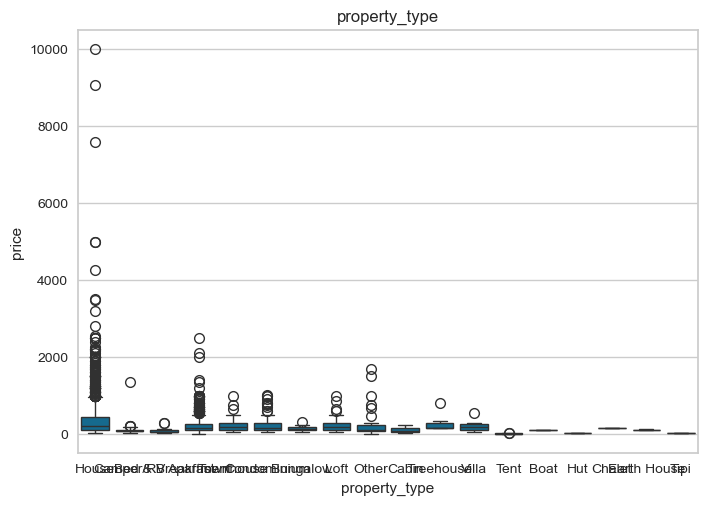

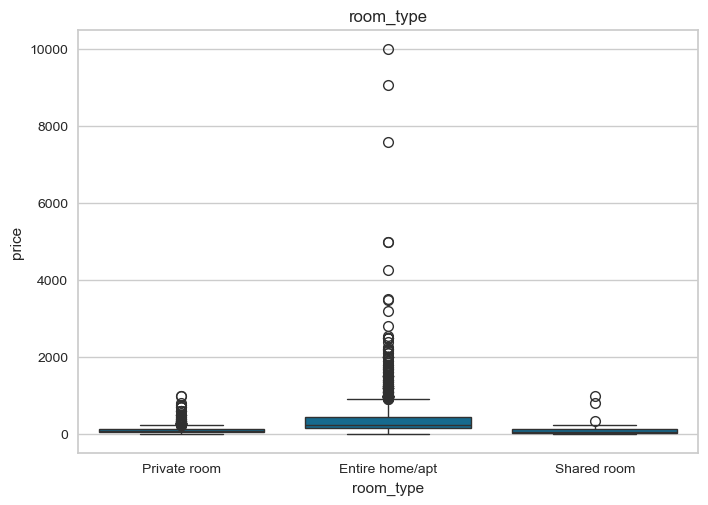

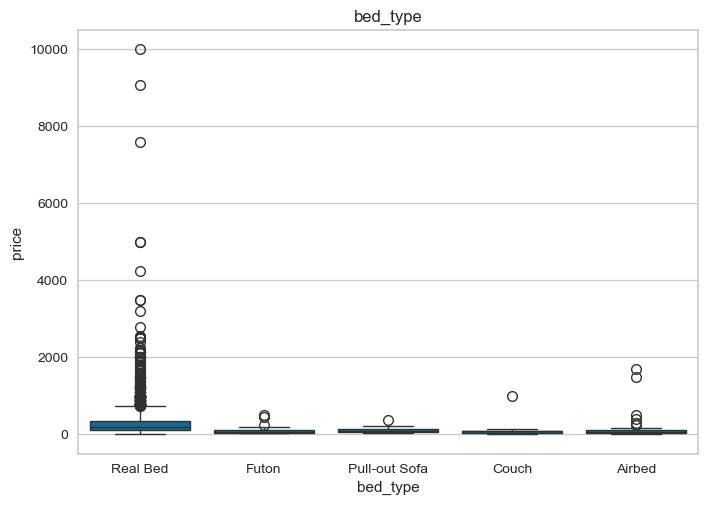

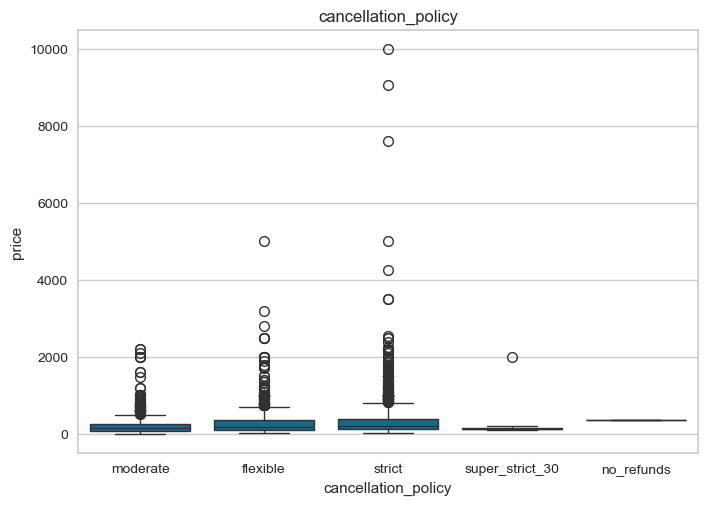

In [40]:
nominal_data = ['neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy'] 
for column in nominal_data:
    sns.boxplot(x=column, y='price', data=airbnb_df)
    plt.title(column)
    plt.show()

In [52]:
variables = stepwise_variables + ['neighbourhood','property_type', 'room_type', 'bed_type', 'cancellation_policy']
X = airbnb_df[variables]
X = pd.get_dummies(X, columns=['neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy'])
X = sm.add_constant(X)
X = X.replace({True: 1, False: 0})
y = airbnb_df['price']
sqrty = np.sqrt(y)

C:\Users\trush\AppData\Local\Temp\ipykernel_20944\2588932013.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({True: 1, False: 0})


In [53]:
nom_num_logreg = sm.OLS(sqrty, X).fit()
print(nom_num_logreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     61.16
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:04:24   Log-Likelihood:                -14304.
No. Observations:                4751   AIC:                         2.884e+04
Df Residuals:                    4637   BIC:                         2.957e+04
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [54]:
full_variables = stepwise_selection(X, sqrty)

Add  bedrooms with p-value 0.0000
Add  has_availability with p-value 0.0000
Add  bathrooms with p-value 0.0000
Add  room_type_Entire home/apt with p-value 0.0000
Add  number_of_reviews with p-value 0.0000
Add  host_identity_verified with p-value 0.0000
Add  property_type_Tent with p-value 0.0000
Add  neighbourhood_Tarrytown with p-value 0.0000
Add  cancellation_policy_moderate with p-value 0.0000
Add  neighbourhood_Old Enfield with p-value 0.0000
Add  accommodates with p-value 0.0000
Add  neighbourhood_Rainey Street with p-value 0.0000
Add  neighbourhood_Zilker with p-value 0.0000
Add  neighbourhood_East Downtown with p-value 0.0000
Add  neighbourhood_Old West Austin with p-value 0.0000
Add  neighbourhood_Travis Heights with p-value 0.0000
Add  host_is_superhost with p-value 0.0000
Add  neighbourhood_Downtown with p-value 0.0000
Add  neighbourhood_South Congress with p-value 0.0000
Add  neighbourhood_Clarksville with p-value 0.0000
Add  neighbourhood_South First with p-value 0.0000
Add

In [55]:
X = X[full_variables]
X = sm.add_constant(X)

final_reg = sm.OLS(sqrty, X).fit()

print(final_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     204.1
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:06:33   Log-Likelihood:                -14364.
No. Observations:                4751   AIC:                         2.880e+04
Df Residuals:                    4717   BIC:                         2.902e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
bedrooms      